# Sprawdzenie zbioru danych

In [40]:
import pandas as pd
import os
import numpy as np

### Podział na dane do Nauki, Testowania oraz Sprawdzania

In [41]:
train_path = "../dataset/Landscape Classification/Training Data/"
test_path = "../dataset/Landscape Classification/Testing Data/"
valid_path = "../dataset/Landscape Classification/Validation Data/"

In [42]:
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

print(f"Number of Classes : {n_classes}\nClass names : {class_names}")

Number of Classes : 5
Class names : ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


### Wizualizacja dystrybucji

In [43]:
import plotly.express as px
import matplotlib.pyplot as plt

class_dis = [len(os.listdir(train_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.2)
fig.update_layout({'title':{'x':0.7}})
fig.show()

In [44]:
class_dis = [len(os.listdir(test_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", hole=0.2)
fig.update_layout({'title':{'x':0.7}})
fig.show()

In [45]:
class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", hole=0.2)
fig.update_layout({'title':{'x':0.7}})
fig.show()

Dane we wszystich zbiorach są równo podzielone na 5 kategorii:
* Wybrzeże
* Pustynia
* Las
* Lodowiec
* Góry

# Ładowanie danych i ich prezentacja

In [46]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import io
from tensorflow import data as tfd
from tensorflow import image as tfi
from keras.preprocessing.image import ImageDataGenerator

### Funckje zamieniające zdjęcie w obiekt do nauki

In [47]:
def decode_image(image):
    image = tfi.decode_jpeg(image, channels=3)
    image = tfi.resize(image, (256,256))
    # Apply any augmentations here.
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

In [48]:
def decode_data(example):
    features = {
        'image':io.FixedLenFeature([], tf.string),
        'label':io.FixedLenFeature([], tf.int64)
    }

    example = io.parse_single_example(example, features)
    image, label = example['image'], example['label']
    image = decode_image(image)
    return image, label

In [49]:
def load_data(file_dir, BATCH_SIZE=32, BUFFER=1000):
    AUTOTUNE = tfd.AUTOTUNE
    file_dir = file_dir + "*.tfrecord"
    files = tfd.Dataset.list_files(file_dir)
    data = tfd.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    data = data.map(decode_data, num_parallel_calls=AUTOTUNE)
    data = data.shuffle(BUFFER).batch(BATCH_SIZE, drop_remainder=True)
    data = data.prefetch(AUTOTUNE)
    return data

In [50]:
def show_images(data, class_names=class_names, model=None, SIZE=(25,25), GRID=[6,6]):

    # Plot Configuration
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)

    # Iterate through the data
    i=1
    for images, labels in iter(data):

        # Select some items randomly
        id = np.random.randint(len(images))
        image, label = tf.expand_dims(images[id], axis=0), class_names[int(labels[id])]

        # Make Prediction
        if model is not None:
            pred = model.predict(image)[0]
            score = np.round(max(pred),2)
            pred_class = class_names[np.argmax(pred)]

            title = f"True : {label}\nPred : {pred_class}\n Score : {score}"
        else:
            title = label

        # plot Images
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(title)

        # Break Loop
        i+=1
        if i>n_images:
            break

    # Final Show
    plt.show()

### Ładowanie danych zapisanych jako .tfrecord

In [51]:
tfr_train_path = "../dataset/Landscape Classification/TFrecords/Train/"
tfr_test_path = "../dataset/Landscape Classification/TFrecords/Test/"
tfr_valid_path = "../dataset/Landscape Classification/TFrecords/Valid/"

In [52]:
train_ds = load_data(file_dir=tfr_train_path)
test_ds = load_data(file_dir=tfr_test_path, BATCH_SIZE=1, BUFFER=500)
valid_ds = load_data(file_dir=tfr_valid_path)
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>


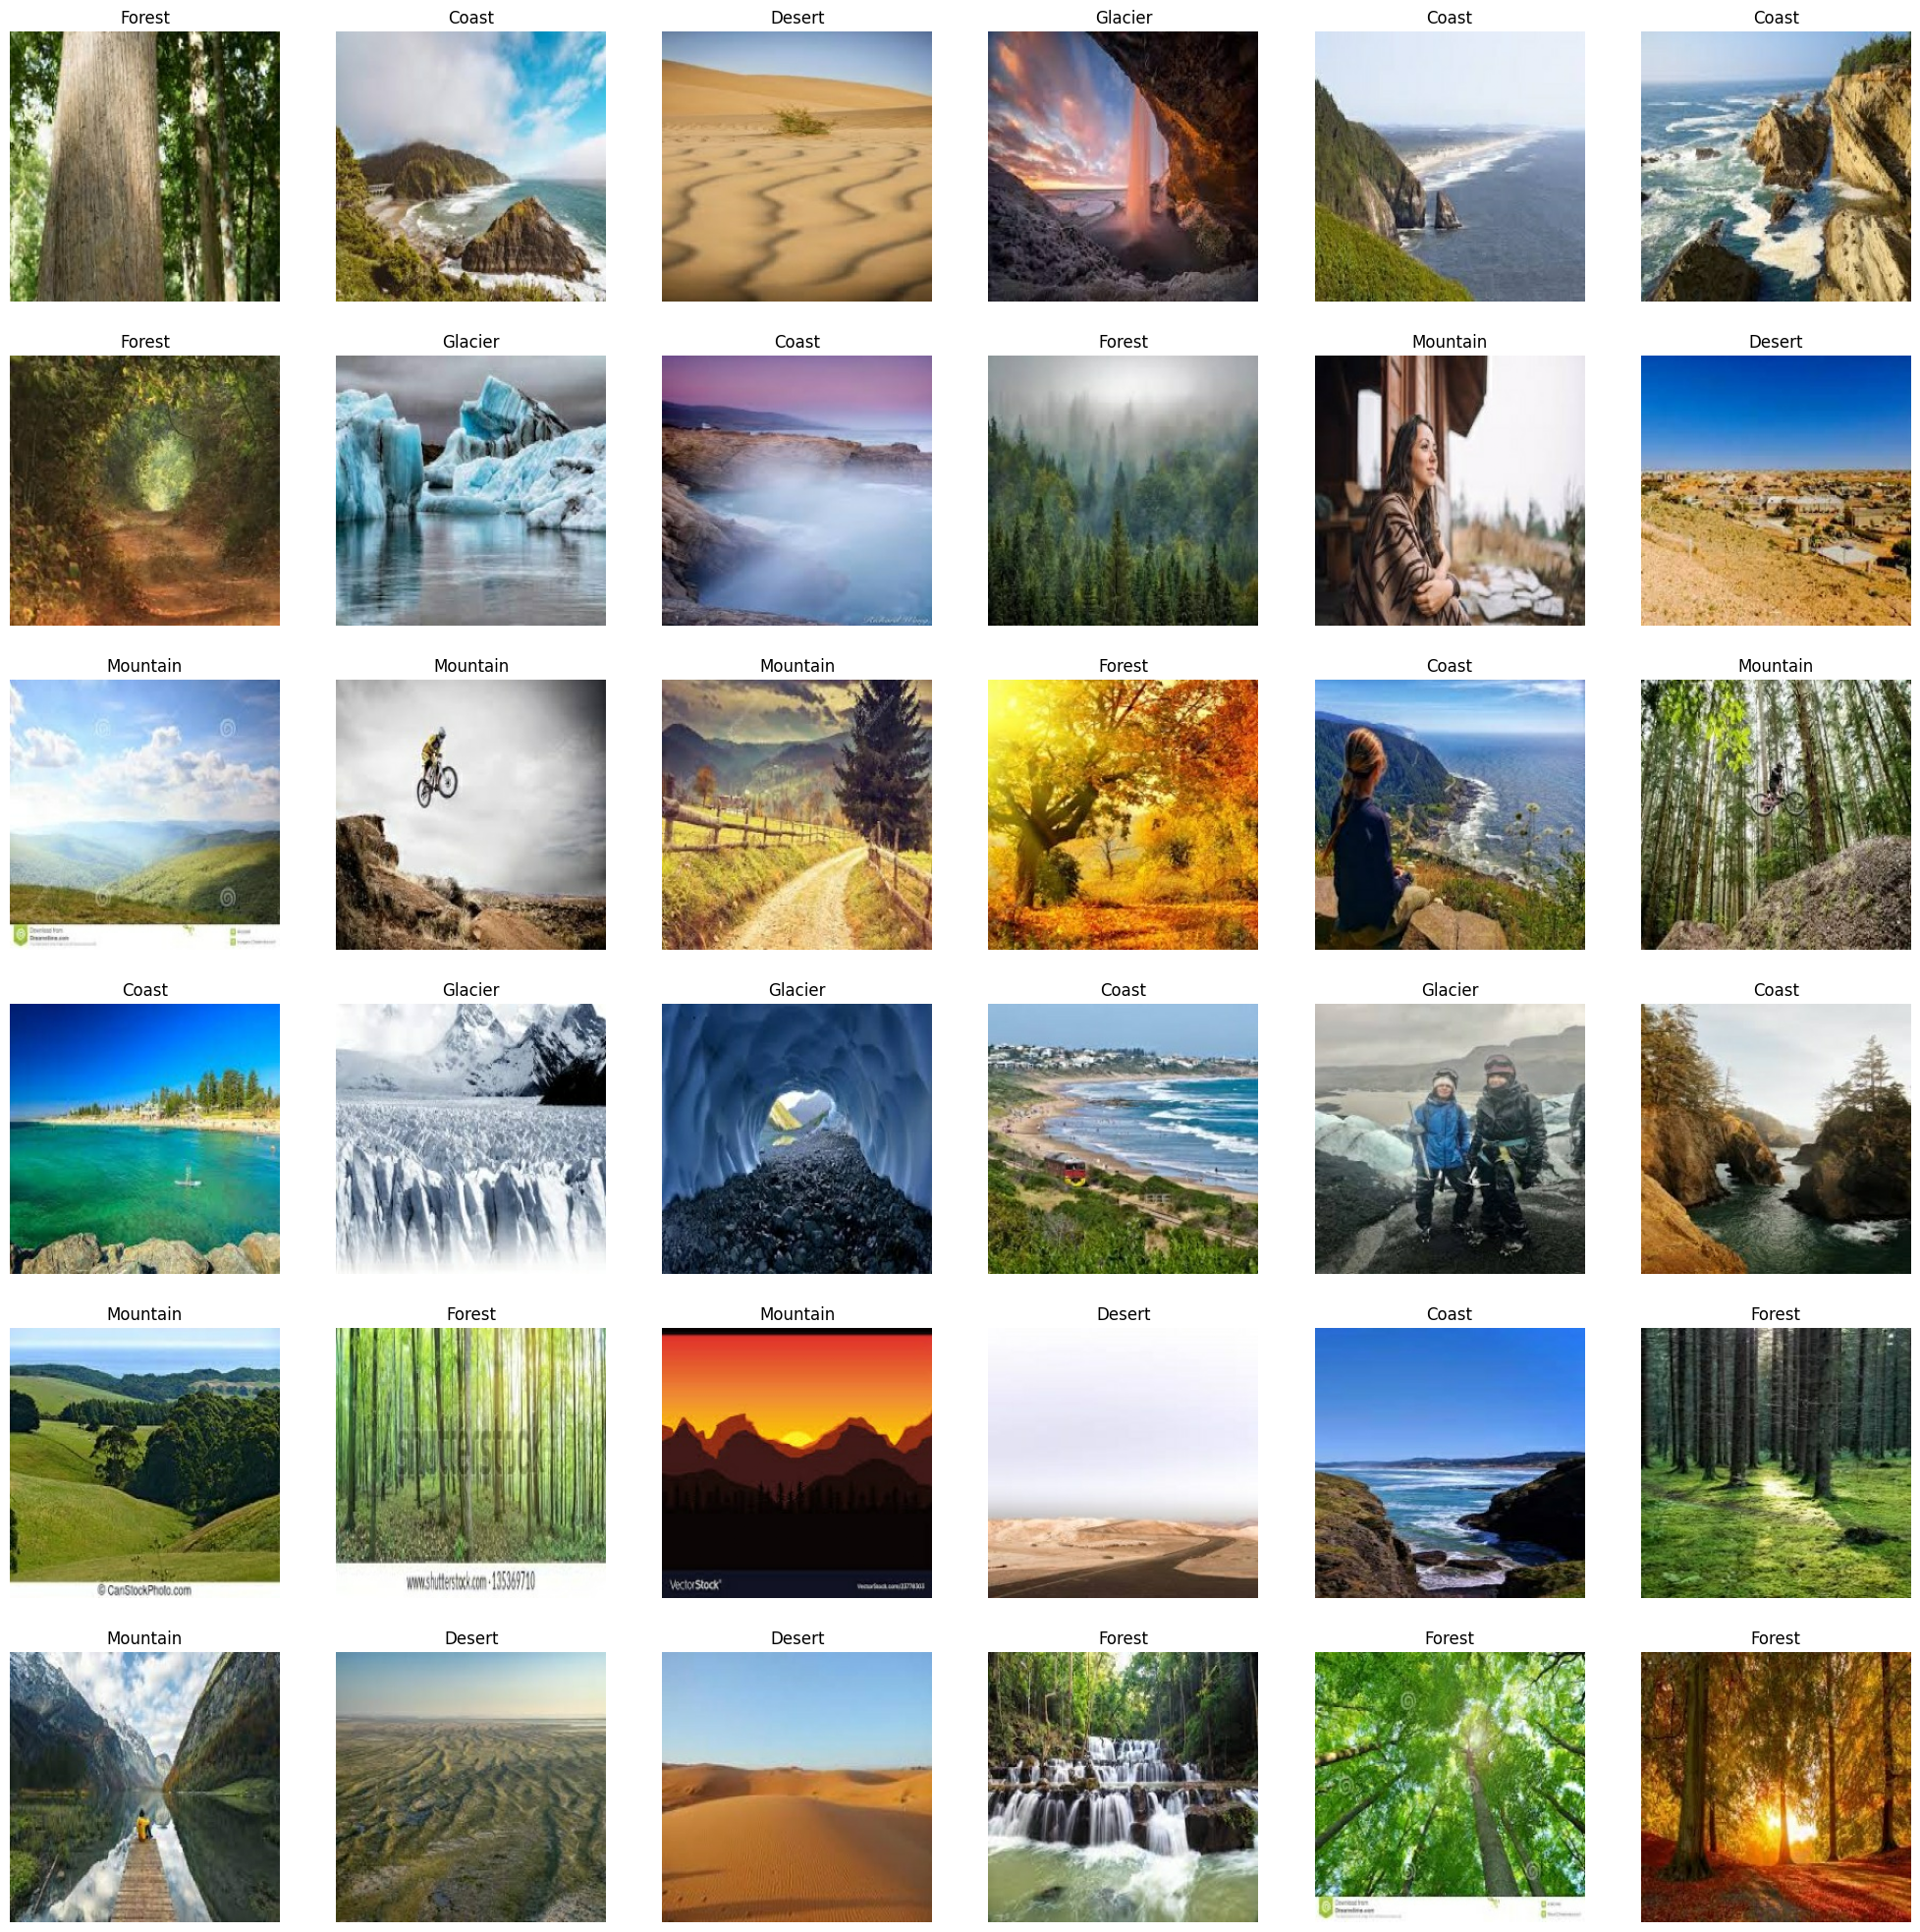

In [53]:
show_images(train_ds)

# Tworzenie modelu

In [54]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

### Struktura modelu oraz Layery

In [64]:
model = Sequential()
model.add(Conv2D(32, (3, 3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 516128)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               132129024 
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 132,131,205
Trainable params: 132,131,205
Non-trainable params: 0
________________________________________

In [67]:
model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10


ValueError: in user code:

    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/alan/.pyenv/versions/3.10.8/envs/AO/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (32, 1) and (32, 5) are incompatible


In [ ]:
model.evaluate(test_ds)

### Zastosowanie modelu

In [ ]:
show_images(test_ds, class_names=class_names, model=model, SIZE=(25,30))